# Nuclei segmentation using U-Net


![Nuclei segmentation](https://pics.spark-in.me/upload/751214b3f2d19ed1cdfcef100d9f8f5a.png)
<center>Image taken from <a href="https://spark-in.me/post/playing-with-dwt-and-ds-bowl-2018">here</a></center>
<br><br>
In this project, we will talk about **object segmentation**, which is a bit different from the task you've done so far. In the object detection task, we have to predict a bounding box that goes around an object at hand, but now we need to make predictions on the pixel level! In other words, object segmentation is a task where the model needs to make predictions for each pixel in an image.

One example of object segmentation is pedestrian detection. In self-driving cars, we would like to make predictions of car's surroundings as precise as possible. Having a pixel-level annotation for each object in a frame is a fantastic way to navigate around.

![Self driving car segmentation](https://cdn.motor1.com/images/mgl/PKgL4/s6/following-a-fire-engine-with-tesla-autopilot-source-greentheonly.jpg)
<center>Image taken from <a href="https://insideevs.com/news/396126/tesla-autopilot-neural-network-advancements/">here</a></center>
<br><br>


### Steps:
1. Import dependencies
2. Custom mask generator
3. Loading the dataset
4. Encoder block
5. Decoder block
6. U-Net
7. Training callbacks
8. Model training
9. Generating predictions

### Topics covered and learning objectives
- Object Segmentation
- Autoencoders
- Generative models
- U-Net
- Generating images as predictions

### Time estimates:
- Reading/Watching materials: 3h 20min
- Exercises: 1h - 1h 30min
<br><br>
- **Total**: ~5h


To learn more about object segmentation:

In [1]:
# reload notebook changes
%load_ext autoreload
%autoreload 2

from IPython.display import IFrame

In [2]:
IFrame("https://www.youtube.com/embed/XMSjOatyH0k", 1000, 500)

**In some cases, IPython widgets do not work!**

If this is the case here is the like for YouTube video from the cell above: https://www.youtube.com/watch?v=XMSjOatyH0k



## Task introduction

![U-Net](https://miro.medium.com/max/700/0*l23lbOWx-_deTkyk.png)

Object segmentation is vital for systems that require high precision. Most health-related tasks are in this category. In this example, we will use data from Data Science Bowl 2018 -  Prediction of nuclei. 

To understand better **why nuclei** here is a paragraph from Kaggle's website:

    Identifying the cells' nuclei is the starting point for most analyses because most of the human body's 30 trillion cells contain a nucleus full of DNA. This genetic code programs each cell. Identifying nuclei allows researchers to identify each cell in a sample, and by measuring how cells react to various treatments, the researcher can understand the underlying biological processes at work.

![](https://storage.googleapis.com/kaggle-media/competitions/dsb-2018/dsb.jpg)
<center>Image taken from <a href="https://www.kaggle.com/c/data-science-bowl-2018">here</a></center>
<br><br>


In [3]:
IFrame("https://www.youtube.com/embed/Dbiq6l50zO8", 1000, 500)

**In some cases, IPython widgets do not work!**

If this is the case, here is the like for YouTube video from the cell above: https://www.youtube.com/watch?v=Dbiq6l50zO8


### Imports for the project

In [4]:
from pathlib import PurePath, Path
import os
import sys
import cv2
import random

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from itertools import chain
from tqdm.notebook import tqdm

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tests import TEST_UNET_MODEL, TEST_DECODER_BLOCK, TEST_ENCODER_BLOCK

## Download the dataset

The dataset is an official part of the Kaggle's Data Science Bowl 2018 competition. To download this dataset, you'll need to be logged in using your Kaggle account and accept the competition rules! Link to the competition and data is [here](https://www.kaggle.com/c/data-science-bowl-2018/data)

Download it from the *[Data](https://www.kaggle.com/c/data-science-bowl-2018/data)* page by clicking onto **Download all**

![](images/download-bowl.png)

Once downloaded, your zip file will contain **seven (7)** zip files! We don't need all of them. 

Extract only these two files:
- stage1_train.zip
- stage1_test.zip

Extract both of them in the working directory or **data/module_6** folder in the root of the repo for the following to work!

Once I've done that, I had two sub-folders, which I renamed to **train** and **test**.
After extracting everything, this was my folder structure:

<pre>
<b>module_6</b>
|__ <b>train</b>
    |______ <b>00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e</b>
            |____<b>images</b> 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e.png
            |____<b>masks</b> [mask_img_1.png, mask_img_2.jpg, mask_img_3.png ...]
    |______ <b>0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9</b>
            |____<b>images</b>: 0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9.png
            |____<b>masks</b>: [mask_img_1.png, mask_img_2.jpg, mask_img_3.png ...]
    |______ <b>...</b>
|__ <b>test</b>
    |______ <b>0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732</b>
            |____<b>images</b> 0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732.png
            |____<b>masks</b> [mask_img_1.png, mask_img_2.jpg, mask_img_3.png ...]
    |______ <b>0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925</b>
            |____<b>images</b>: 0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925.png
            |____<b>masks</b>: [mask_img_1.png, mask_img_2.jpg, mask_img_3.png ...]
    |______ <b>...</b>
</pre>

For each image, there are several mask images (for each cell individually). In the data preprocessing stage, we will need to combine all of these masks to create one single mask per image, acting as the target for our U-Net.

In [5]:
IMG_SIZE = (128, 128, 1)

# CHANGE THIS IF YOU NAMED YOUR DATA FOLDER DIFFERENTLY
REPO_DIR = Path(os.getcwd()).parent

# Note: Please put the data into the data folder in the root of the repo for the following to work!
TRAIN_PATH = REPO_DIR / "data/module_6/train"
TEST_PATH = REPO_DIR / "data/module_6/test"

## Exercise 1 Making targets from masks

In this Data Science bowl, the authors provided us with a bit of a challenge - to make our targets. For each image, we have between 1 and 300 separate masks! Having tons of images as our targets will make the learning process for U-Net much harder. 

To overcome this, we will create one single target image, which will be cross-over from all the masks provided for that image.

Our original masks look like this:

![](images/masks.png)

From this, we will end up with this:

![](images/final-mask.png)

As you can see, the final mask is made from many white spots, where each of these dots was an image for itself.

Your task now is to complete the **make_mask_target** function, which does precisely this. 

Here are the steps to follow:

1. Make a matrix of zeros using np.zeros function. This matrix should be the size of IMG_SIZE[0] x IMG_SIZE[1] x 1 
    NOTE: dtype is np.bool because we would like to binarize the output for predictions
    
2. Iterate through all mask images located in the *mask_folder_path* (input of the function)

3. Load each mask using OpenCV in the GRAYSCALE reading mode 

4. Binarize the input using the OTSU threshold technique 
   - Here is how-to: https://stackoverflow.com/questions/7624765/converting-an-opencv-image-to-black-and-white
   

5. Resize the image to be (IMG_SIZE[0], IMG_SIZE[1])

6. Expend dimensions on using np.expand_dims(matrix, axis=-1)

7. Merge the matrix created in step 1 with the matrix from step 6 using np.maximum
    - Using this method will take maximum values for all places in the matrix, preserving all masks already merged in the process
    

8. Return matrix from step 1 with all masks merged into it

In [6]:
def make_mask_target(mask_folder_path):
    """
    Creates target images from many nucleai masks.

    Args:
        mask_folder_path :string: - path to the folder that contains all the mask for an input image
    """
    target = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 1), dtype=np.bool_)

    for mask_candidate in os.listdir(masks_folder):
        mask_candidate = cv2.imread(os.path.join(masks_folder, mask_candidate), cv2.IMREAD_GRAYSCALE)

        # EXERCISE
        (thresh, im_bw) = cv2.threshold(mask_candidate, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        mask_candidate = cv2.resize(im_bw, (IMG_SIZE[0], IMG_SIZE[1]), cv2.INTER_LINEAR)

        mask_candidate = np.expand_dims(mask_candidate, axis=-1)
        target = np.maximum(target, mask_candidate)

    return target

### Loading the dataset into memory

In [7]:
# !pip install ipywidgets

In [8]:
X_train = []
y_train = []

for i, folder in tqdm(enumerate(os.listdir(TRAIN_PATH.__str__())), total=len(os.listdir(TRAIN_PATH.__str__()))):
    path = TRAIN_PATH / folder
    img_folder =  path / "images"
    masks_folder = path / "masks"

    # Load image in the GrayScale format
    img = cv2.imread((img_folder / (path.parts[-1] + ".png")).__str__(), cv2.IMREAD_GRAYSCALE)

    # Resize image to the IMG_SIZE
    if img is None:
        continue
    img = cv2.resize(img, (IMG_SIZE[0], IMG_SIZE[1]), cv2.INTER_LINEAR)
    X_train.append(img)

    # Creating the target mask
    target = make_mask_target(masks_folder)

    y_train.append(target / 255.0)

X_train = np.expand_dims(np.array(X_train), -1)
y_train = np.array(y_train)

  0%|          | 0/671 [00:00<?, ?it/s]

[ WARN:0@7.593] global loadsave.cpp:241 findDecoder imread_('/Users/markus/Development/dsr/Advanced-Computer-Vision/data/module_6/train/.DS_Store/images/.DS_Store.png'): can't open/read file: check file path/integrity


### Loading test images to check model preformance at the end

In [9]:
# Get and resize test images
X_test = []

for i, folder in tqdm(enumerate(os.listdir(TEST_PATH.__str__())), total=len(os.listdir(TEST_PATH.__str__()))):
    if folder == ".DS_Store":
        continue
    path = TEST_PATH / folder
    img_folder =  path / "images"

    # Load image in he RGB format
    # if img is None:
    #     continue
    img = cv2.imread((img_folder / (path.parts[-1] + ".png")).__str__(), cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (IMG_SIZE[0], IMG_SIZE[1]), cv2.INTER_LINEAR)
    X_test.append(img)

X_test = np.array(X_test)

  0%|          | 0/66 [00:00<?, ?it/s]

In [10]:
X_test.shape

(65, 128, 128)

## Exercise 2 Encoder block

Before we start building the architecture, it is important to learn the underlying concet of U-Net - Autoencoders! 

Intro to autoencoders: https://www.jeremyjordan.me/autoencoders/
Examples of AE applications: https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726


In this exercise, you'll complete the **encoder_block** function. This function will be used to create a single block in the first part of the network. 

![](https://miro.medium.com/max/384/1*yGu1oXPeqEvbKRuWL0z3Dw.png)

It accepts two arguments *inputs* from a previous layer in the network, and the second one is *features* used for Conv2D layers.

Each encoder block has **four (4)** parts.
1. Conv2D layer, which gets the number of features from the argument of the function, 3x3 kernel, and activation is ReLu. Padding is "same"
2. Dropout layer with 0.2 drop rate
3. Conv2d layer with the same set of arguments as the first convolutional layer
4. Finish the encoder block with MaxPooling2d layer with a pool size of 2x2

NOTE: This function should return **TWO** things
    - Output from the 2nd Conv2d layer (output from this layer will be used to concatenate with decoder layers)
    - Output from the MaxPooling layer (this is the regular output used as a previous layer in the network)

In [11]:
def encoder_block(X, features):
    """
    Create an encoder_block (layer) for the U-Net

    Args:
        X - input from the previous layer
        features :int: - number of features used in Conv2D layers
    """
    X = Conv2D(features, (3, 3), activation='relu', padding='same') (X)
    X = Dropout(0.2) (X)
    enX = Conv2D(features, (3, 3), activation='relu', padding='same') (X)
    X = MaxPooling2D(pool_size=(2, 2)) (X)
    return X, enX

In [12]:
# RUN THIS CELL TO TEST YOUR CODE
TEST_ENCODER_BLOCK(encoder_block)  # TODO fix

2024-11-02 12:50:20.706549: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-11-02 12:50:20.706571: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-11-02 12:50:20.706583: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-11-02 12:50:20.706600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-02 12:50:20.706611: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Exercise 3 Decoder block

In this exercise, you'll complete the **decoder_block** function. This function will be used to create a single block in the second part of the network. 

![](images/decoder-illustration.png)

The decoder block accepts 3 arguments *inputs* from a previous layer in the network, output from a corresponding encoder layer, and *features* used for Conv2D layers.

Each Decoder block has **five (4)** parts/steps

1. Start with Conv2DTranspose with the number of features equal to the argument from the function, 2x2 kernel, 2x2 strides, and padding is equal to "same"
    - This layer is used to increase the size of the input by two (e.g., if the input is 16x16, the output will be 32x32)
2. The second step is the most important step for the U-Net architecture - Concatenating corresponding encoder output with step 1. HINT: use tf.concat([], axis=3)
3. Conv2D layer, which gets the number of features from the argument of the function, 3x3 kernel, and activation is ReLu. Padding is "same"
4. Dropout layer with 0.2 drop rate
5. Conv2d layer with the same set of arguments as the Conv2D from step 3

Learning resources:
- Transposed convolutions https://towardsdatascience.com/transposed-convolution-demystified-84ca81b4baba

In [13]:
from tensorflow.keras import layers

def decoder_block(X, outp_enc_layer, features):
    """
    Create an decoder_block (layer) for the U-Net

    Args:
        X - input from the previous layer
        outp_enc_layer - Output from a corresponding encoder layer
        features :int: - number of features used in Conv2D and Conv2DTranspose layers
    """
    X = Conv2DTranspose(features, (2,2), strides=(2,2), padding="same") (X)
    X = layers.Concatenate(axis=3)([X, outp_enc_layer])
    X = Dropout(0.2) (X)
    X = Conv2D(features, 3, activation="relu", padding="same") (X)
    return X

In [14]:
# RUN THIS CELL TO TEST YOUR CODE
TEST_DECODER_BLOCK(decoder_block, encoder_block)

## Exercise 3 Complete the U-Net architecture

On the image here, you can see the architecture we are building here.

![](images/u-net.png)


In [15]:
IFrame("https://www.youtube.com/embed/azM57JuQpQI", 1000, 500)

**In some cases, IPython widgets do not work!**

If this is the case, here is the like for YouTube video from the cell above: https://www.youtube.com/watch?v=azM57JuQpQI


In [16]:
IFrame("https://www.youtube.com/embed/oLvmLJkmXuc", 1000,500)

**In some cases, IPython widgets do not work!**

If this is the case, here is the like for YouTube video from the cell above: https://www.youtube.com/watch?v=oLvmLJkmXuc


- Understanding Semantic Segmentation with UNET https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

In the cell below, fill in the missing parts to get the same architecture as represented in the picture. Inputs, the middle part, and the output layer are already given to you.

Encoder hints:
1. Encoder is made out of 4 **encoder_blocks** 
    - First one has 16 features
    - Second one, 32, features
    - Third one, 64 
    - Fourth block has 128

2. Each encoder block returns two values, real outputs and outputs used to concatenate with corresponding decoder block
3. Decoder block has  4 **decoder_blocks**
    - First has 128, and this block is paired with encoder block 4
    - Second block has 64, and it's paired with 3rd encoder block
    - Third block has 32, and corresponding encoder block is the 2nd one
    - Fourth one has 16 and pairs it with the first encoder block

In [17]:
inputs = Input((128, 128,1))

# YOUR CODE GOES HERE
X, enc1 = encoder_block(inputs, 16)
X, enc2 = encoder_block(X, 32)
X, enc3 = encoder_block(X, 64)
X, enc4 = encoder_block(X, 128)

mid = Conv2D(256, (3, 3), activation='relu', padding='same') (X)
mid = Dropout(0.3) (mid)
mid = Conv2D(256, (3, 3), activation='relu', padding='same') (mid)

# YOUR CODE GOES HERE
dec1 = decoder_block(mid, enc4, 128)
dec2 = decoder_block(dec1, enc3, 64)
dec3 = decoder_block(dec2, enc2, 32)
dec4 = decoder_block(dec3, enc1, 16)

# don't forget to add output from the last decoder alyer to the output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid') (dec4)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])  # TODO dice

In [25]:
# RUN THIS CELL TO TEST YOUR CODE
TEST_UNET_MODEL(model)

model.count_params() 1744737
model.layers [<InputLayer name=input_layer_3, built=True>, <Conv2D name=conv2d_5, built=True>, <Dropout name=dropout_3, built=True>, <MaxPooling2D name=max_pooling2d_2, built=True>, <Conv2D name=conv2d_7, built=True>, <Dropout name=dropout_4, built=True>, <MaxPooling2D name=max_pooling2d_3, built=True>, <Conv2D name=conv2d_9, built=True>, <Dropout name=dropout_5, built=True>, <MaxPooling2D name=max_pooling2d_4, built=True>, <Conv2D name=conv2d_11, built=True>, <Dropout name=dropout_6, built=True>, <MaxPooling2D name=max_pooling2d_5, built=True>, <Conv2D name=conv2d_13, built=True>, <Dropout name=dropout_7, built=True>, <Conv2D name=conv2d_14, built=True>, <Conv2DTranspose name=conv2d_transpose_1, built=True>, <Conv2D name=conv2d_12, built=True>, <Concatenate name=concatenate_1, built=True>, <Dropout name=dropout_8, built=True>, <Conv2D name=conv2d_15, built=True>, <Conv2DTranspose name=conv2d_transpose_2, built=True>, <Conv2D name=conv2d_10, built=True>, <C

## Exercise 4 (Optional) Model callbacks

Define **EarlyStopping** callback. You can use arguments of choice here
Define **ModelCheckpoint** callback, use save_best_only=True, choose whatever name you want

In [ ]:
earlystopping_callback = EarlyStopping(patience=5, verbose=1)
checkpoint_callback = ModelCheckpoint('model-dsbowl2018-1.keras', verbose=1, save_best_only=True)

## Exercise 5 Train the model

Call the **fit** function on the model and provide all the necessary arguments. In the cell below, you'll find already pre-defined hyperparameters for training, but try to experiment with them.

NOTE: If you choose to solve **Exercise 4** don't forget to put them in the fit function 
- https://keras.io/api/callbacks/

In [20]:
BATCH_SIZE=16
EPOCHS=20
VALIDATION_SPLIT=0.1

In [21]:
results = model.fit(X_train, y_train, validation_split=VALIDATION_SPLIT, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    callbacks=[earlystopping_callback, checkpoint_callback])

Epoch 1/20


2024-11-02 12:50:23.438626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6024 - loss: 2.7587
Epoch 1: val_loss improved from inf to 0.54838, saving model to model-dsbowl2018-1.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 264ms/step - accuracy: 0.6060 - loss: 2.7209 - val_accuracy: 0.8603 - val_loss: 0.5484
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8479 - loss: 0.5033
Epoch 2: val_loss improved from 0.54838 to 0.21374, saving model to model-dsbowl2018-1.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.8479 - loss: 0.5014 - val_accuracy: 0.8776 - val_loss: 0.2137
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8706 - loss: 0.2338
Epoch 3: val_loss improved from 0.21374 to 0.16013, saving model to model-dsbowl2018-1.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.8708 - loss: 0.2332 - val_accuracy: 0.9054 - val_loss: 0.1601
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8963 - loss: 0.1784
Epoch 4: val_loss improved from 0.16013 

### Predicting using the trained model

We call **model.predict** and provide the **X_test** set to it to make a prediction. Our model will make predictions going from 0 to 1, but we need to binarize the output. To do that, we can simply add **> 0.5** after that, which will make the prediction 1 (True) or 0 (False) for this comparison. 

In [22]:
preds = model.predict(X_test, verbose=1) > 0.5

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 553ms/step


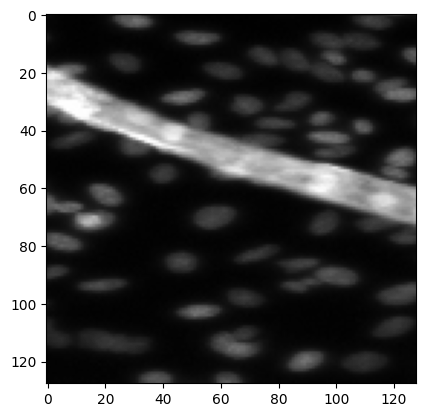

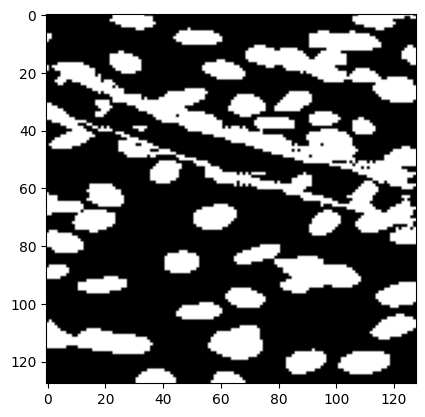

In [23]:
ix = random.randint(0, len(preds))
plt.imshow(X_test[ix], cmap='gray')
plt.show()
plt.imshow(np.squeeze(preds[ix]), cmap='gray')
plt.show()

# Reading homework - Mask R-CNN


Now that you know how U-Net and R-CNN work, it's time to read about an R-CNN version used for semantic segmentation called Masked R-CNN. We won't be implementing it here, but you'll have a lot of resources that go through code parts.


### Topics covered and learning objectives
- Mask R-CNN

### Time estimates:
- Reading/Watching materials: 1h
<br><br>
- **Total**: ~1h



- Simple introduction to Mask R-CNN https://alittlepain833.medium.com/simple-understanding-of-mask-rcnn-134b5b330e95 
- Video introduction to semantic segmentation https://www.youtube.com/watch?v=4tkgOzQ9yyo
- Get deeper into Mask R-CNN with pieces of code https://towardsdatascience.com/computer-vision-instance-segmentation-with-mask-r-cnn-7983502fcad1
- Keras and Mask R-CNN https://machinelearningmastery.com/how-to-perform-object-detection-in-photographs-with-mask-r-cnn-in-keras/
- Implementation and project with Mask R-CNN https://towardsdatascience.com/webcam-object-detection-with-mask-r-cnn-on-google-colab-b3b012053ed1

Try it out in the cloud:
https://colab.research.google.com/github/tensorflow/tpu/blob/master/models/official/mask_rcnn/mask_rcnn_demo.ipynb